In [103]:
maf_file_path = 'data/RESPOND_247_coding_final.maf'
expression_file_path = 'data/Expression_remove_BE.txt'
target_gene='RPL10'

import pandas as pd
import numpy as np
from statistics import mean 
from scipy.stats import ranksums
import matplotlib.pylab as plt
from statsmodels.stats import multitest


In [104]:
def load_maf_data(file_path):
    # Define columns of interest
    columns = ["Hugo_Symbol", "Tumor_Sample_Barcode"]
    df = pd.read_csv(file_path, sep='\t', comment="#", usecols=columns)
    df.rename(columns={'Hugo_Symbol': 'gene', 'Tumor_Sample_Barcode': 'sample'}, inplace=True)
    df['mutation'] = 1
    return df
    
maf_df = load_maf_data(maf_file_path)



In [197]:
def log2(value):
    return np.log2(value + 1)

def load_txt_file_into_dataframe(file_path):
    # Read the .txt file into a pandas DataFrame
    df = pd.read_csv(file_path, sep='\t')  # Adjust the separator if needed

    # take log2 of expression data to scale expression data
    df = df.map(log2)

    return df


# Call the load_txt_file_into_dataframe function
expression_df = load_txt_file_into_dataframe(expression_file_path)

In [161]:
def reformat_expression_data(df):
    # Combine column names and index names into rows for every element
    melted_df = pd.melt(df.reset_index(), id_vars=['index'], var_name='column', col_level=0)

    # Rename columns
    melted_df.rename(columns={'index': 'gene', 'column': 'sample', 'value': 'gene_expression'}, inplace=True)

    return melted_df


expression_df_melted = reformat_expression_data(expression_df)

In [173]:
def preprocess_and_combine_mutation_expression(maf_df, expression_df):
    ''' filter the expression data to those that have whole genome sequencing 
     i.e. appear in the mutation data frame (maf)
     join mutation and expression data
     '''
    
    exon_seq_samples = maf_df['sample'].unique()
    filtered_expression_df = expression_df[expression_df['sample'].isin(exon_seq_samples)]
    
    all_rows = expression_df.shape[0]
    filt_rows = filtered_expression_df.shape[0]
    
    percentage_filtered = (all_rows - filt_rows) / all_rows
    
    print('fraction of rows filtered is', percentage_filtered)

    express_mut_genes_df = pd.merge(maf_df, filtered_expression_df, on=['gene', 'sample'], how='right')

    express_mut_genes_df['mutation'].fillna(0, inplace=True)

    return express_mut_genes_df


mutation_expression_df_melted =  preprocess_and_combine_mutation_expression(maf_df, expression_df_melted)
    

fraction of rows filtered is 0.2865853658536585


In [174]:
def calculate_log_fold(list_mutated, list_non_mutated): 
    mean_mutated = mean(list_mutated)
    mean_non_mutated = mean(list_non_mutated) + 0.000001
    return np.log2(mean_mutated/mean_non_mutated)

In [175]:
def calculate_pvalue_wilcox_ranksum(list_mutated, list_non_mutated):
     return ranksums(list_mutated, list_non_mutated).pvalue

In [176]:
def calculate_adjusted_pvalue(pvalues, method='fdr_bh'):
    _, corrected_pvalues, _, _ = multitest.multipletests(pvalues, method=method)
    return corrected_pvalues


In [192]:
def generate_stats_per_gene(express_mut_genes_df, target_gene):
    """
    Given expression and mutation data calculates LogFC, pvalue, mean of expression per gene 
    for a given target_gene 
    
    """
    gene_df = express_mut_genes_df[express_mut_genes_df['gene']==target_gene]

    mutated_samples = gene_df[gene_df['mutation'] == 1]['sample']
    non_mutated_samples = gene_df[gene_df['mutation'] == 0]['sample']
    
    mutated_individuals_expression = express_mut_genes_df[express_mut_genes_df['sample'].isin(mutated_samples)]
    
    non_mutated_individuals_expression = express_mut_genes_df[express_mut_genes_df['sample'].isin(non_mutated_samples)]

    # gather data of mutated and non-mutated genes into lists
    mutated_individuals_data = mutated_individuals_expression.groupby(['gene'])['gene_expression'].apply(
    lambda x: list(x)).to_frame().reset_index().rename(columns={'gene_expression': 'gene_expression_mutated'})
    non_mutated_individuals_data = non_mutated_individuals_expression.groupby(['gene'])['gene_expression'].apply(
    lambda x: list(x)).to_frame().reset_index().rename(columns={'gene_expression': 'gene_expression_non_mutated'})

    # combine mutated and unmutated data into one df
    combined_data= pd.merge(mutated_individuals_data, non_mutated_individuals_data, on='gene', how='inner')

    # calculate fold change and p-value
    combined_data['logFC']= combined_data.apply(
        lambda x: calculate_log_fold(x.gene_expression_mutated, x.gene_expression_non_mutated), axis=1)
    combined_data['pvalue'] = combined_data.apply(
        lambda x: calculate_pvalue_wilcox_ranksum(x.gene_expression_mutated, x.gene_expression_non_mutated), axis=1)
    combined_data['expression_mutated_mean'] = combined_data['gene_expression_mutated'].apply(mean)
    combined_data['expression_nonmutated_mean'] = combined_data['gene_expression_non_mutated'].apply(mean)
 
    # Clip outliers in 'logFC' column
    combined_data['logFC'] = combined_data['logFC'].clip(lower=-10, upper=10)

    # calculate adjusted p-value
    combined_data['adjusted_pvalue'] = calculate_adjusted_pvalue(combined_data['pvalue'].values)

    # Output data to csv 
    combined_data.drop(columns=['gene_expression_mutated', 'gene_expression_non_mutated'], inplace=True)
    
    output_file_path_name = f'{mutated_samples.count()}_{non_mutated_samples.count()}_{target_gene}'
    print(f"outputting data to {output_file_path_name}")
    combined_data.to_csv(output_file_path_name, index=False)

    return combined_data, output_file_path_name, mutated_samples


In [194]:
volcano_plot_df, gene_file_path, individuals_mutated_target_gene = generate_stats_per_gene(mutation_expression_df_melted, target_gene)

/var/folders/87/3s003r291fv10lqn34cwt0c80000gn/T/ipykernel_16622/2450995287.py:4: RuntimeWarning: divide by zero encountered in log2
  return np.log2(mean_mutated/mean_non_mutated)


outputting data to 5_112_RPL10


In [157]:
volcano_plot_df.head(4)

,gene,logFC,pvalue,expression_mutated_mean,expression_nonmutated_mean,adjusted_pvalue
0,A1BG,-0.836169,0.522106,4.434262,7.916502,0.996788
1,A1CF,0.345556,0.594521,1.074431,0.845581,0.996788
2,A2M,-0.357496,0.496169,177.400000,227.284987,0.996788
3,A2ML1,0.654276,0.140050,2.962276,1.882211,0.996788


## generate heatmap of top 100 differentially expressed genes

In [222]:
n = 100  

# Get the indices of the top n rows based on absolute values of 'logFC'
# get the genes most diff expressed (high log FC values)
# if we exclude -10, 10 values 
top_n_indices = volcano_plot_df[volcano_plot_df['logFC'].abs() != 10]['logFC'].abs().nlargest(n).index
top_n_rows = volcano_plot_df.loc[top_n_indices].set_index('gene')

# go back to the expression df and make a heatmap of the top n genes
expression_df_heatmap = expression_df.loc[top_n_rows.index]



In [183]:
# can check mutation status of genes by checking individuals_mutated_target_gene

In [223]:
expression_df_heatmap

,RESPOND_10100218,RESPOND_10100291,RESPOND_10100412,RESPOND_10100478,RESPOND_10100596,RESPOND_10100615,RESPOND_10100801,RESPOND_10100884,RESPOND_10100899,RESPOND_10100952,...,RESPOND_80100242,RESPOND_80100313,RESPOND_80100345,RESPOND_80100411,RESPOND_80100526,RESPOND_80100556,RESPOND_80100590,RESPOND_81100031,RESPOND_40100842,RESPOND_80100259
gene,,,,,,,,,,,,,,,,,,,,,
TMEM238L,0.000000,0.000000,0.0,0.000000,0.000012,0.000000e+00,0.000003,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000025,0.000000
RN7SL321P,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
RNVU1-19,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.915644,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.471448,0.000000
TNFSF12-TNFSF13,0.000000,0.541623,0.0,0.000000,0.000000,5.766168e-15,0.000000,1.318167e-09,0.818079,0.001769,...,1.000000,0.000000,0.0,0.645963,0.000000,1.000000,0.515264,4.484797e-15,0.391062,0.674179
GSX1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.060725,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMEM95,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,3.653134e-01,0.327530,0.000000,...,0.278245,0.000000,0.0,0.000000,0.000000,1.584963,0.000000,8.161212e-02,0.137817,0.000000
GHRH,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.484984,0.000000
SLC5A12,0.087804,0.004402,0.0,0.058881,0.098823,0.000000e+00,0.000000,2.834775e-01,0.042350,0.000000,...,0.138306,0.267165,0.0,0.434406,0.144109,0.455188,0.306176,7.027828e-03,0.018087,0.751645


In [218]:
# # # Cluster the rows and columns using hierarchical clustering
# clustered_df = sns.clustermap(expression_df_heatmap, 
#                               method='average', 
#                               cmap='viridis',
#                               annot=True, 
#                               fmt=".1f", 
#                               linewidths=.5)

# # # Show the plot
# plt.show()



Row Clusters:
Cluster 1: Index(['MYL2'], dtype='object', name='gene')
Cluster 2: Index(['MYH7'], dtype='object', name='gene')
Cluster 3: Index(['MAGEA6'], dtype='object', name='gene')
Cluster 4: Index(['MAGEA3'], dtype='object', name='gene')
Cluster 5: Index(['CACNA1S'], dtype='object', name='gene')
Cluster 6: Index(['XIRP2'], dtype='object', name='gene')
Cluster 7: Index(['KLHL40'], dtype='object', name='gene')
Cluster 8: Index(['CT83'], dtype='object', name='gene')
Cluster 9: Index(['RNU6-1099P'], dtype='object', name='gene')
Cluster 10: Index(['TRIM49C'], dtype='object', name='gene')
Cluster 11: Index(['TRIM49'], dtype='object', name='gene')
Cluster 12: Index(['BHLHE23'], dtype='object', name='gene')
Cluster 13: Index(['H2AP'], dtype='object', name='gene')
Cluster 14: Index(['PRDM14'], dtype='object', name='gene')
Cluster 15: Index(['PTH2'], dtype='object', name='gene')
Cluster 16: Index(['OR5T2', 'OR5T1', 'RN7SKP15'], dtype='object', name='gene')
Cluster 17: Index(['OCSTAMP'], dtyp

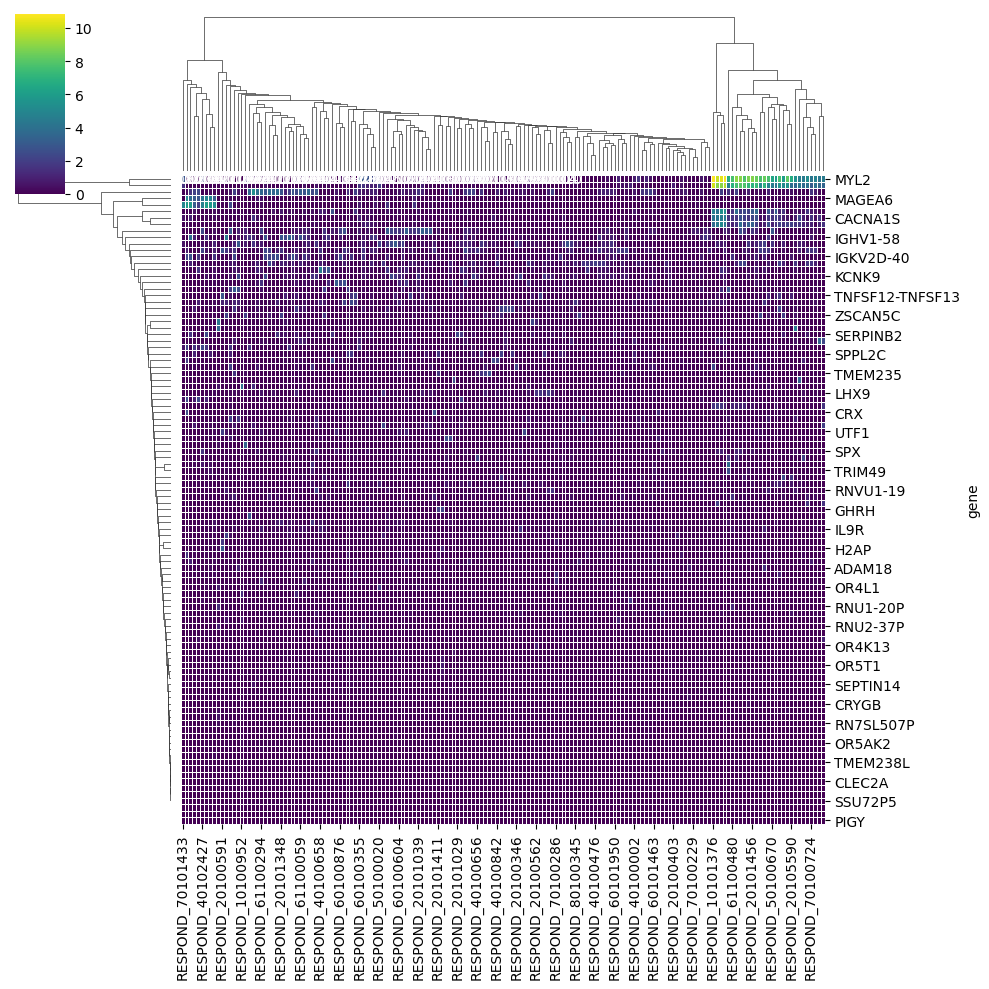

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import fcluster, linkage

# Cluster the rows and columns using hierarchical clustering
row_linkage = linkage(expression_df_heatmap, method='average')
col_linkage = linkage(expression_df_heatmap.T, method='average')

# Define a threshold to cut the dendrogram and form clusters
row_threshold = 0.7  # had to increase to get more members in each group
col_threshold = 0.7  

# Assign cluster labels using cluster
row_clusters = fcluster(row_linkage, row_threshold, criterion='distance')
col_clusters = fcluster(col_linkage, col_threshold, criterion='distance')

# Print items in each cluster
print("Row Clusters:")
for cluster in np.unique(row_clusters):
    cluster_items = expression_df_heatmap.index[row_clusters == cluster]
    print(f"Cluster {cluster}: {cluster_items}")

print("\nColumn Clusters:")
for cluster in np.unique(col_clusters):
    cluster_items = expression_df_heatmap.columns[col_clusters == cluster]
    print(f"Cluster {cluster}: {cluster_items}")


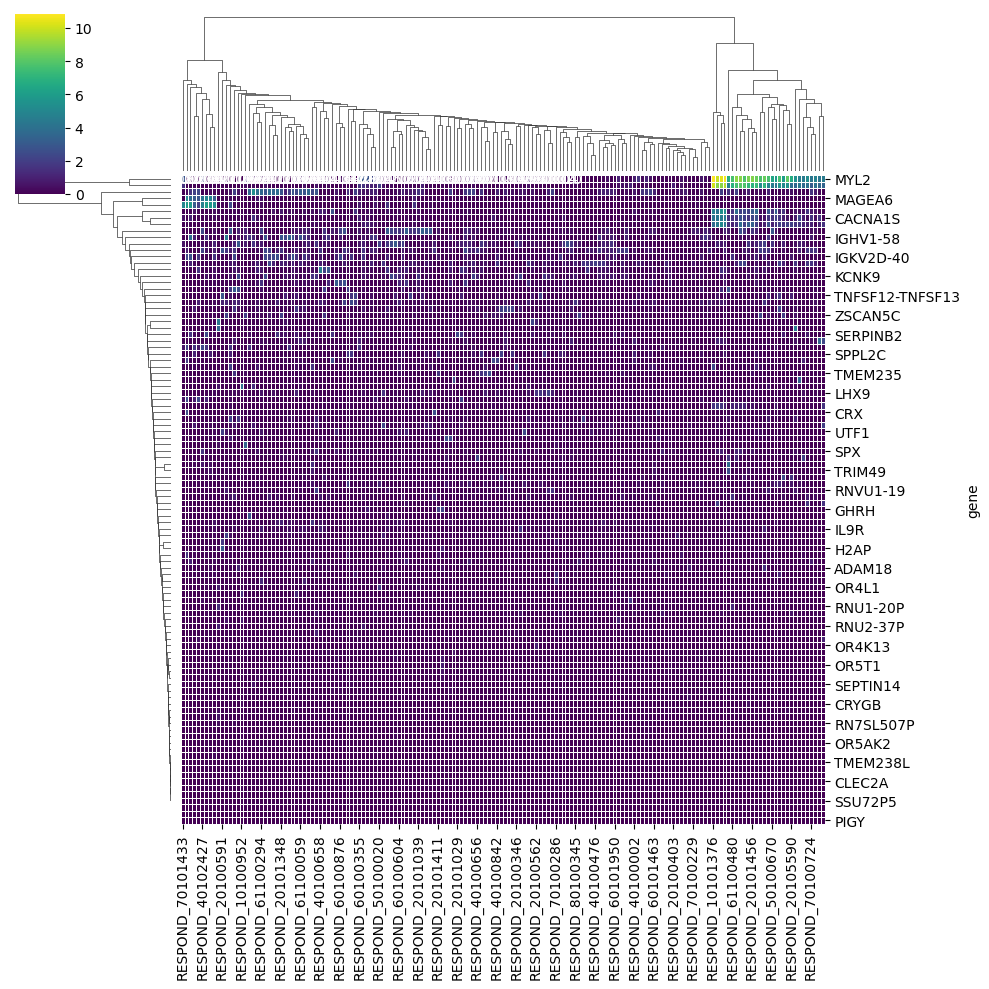

In [247]:

# Create a clustered heatmap
sns.clustermap(expression_df_heatmap, row_linkage=row_linkage, col_linkage=col_linkage,
               cmap='viridis', annot=True, fmt=".1f", linewidths=.5)

# Show the plot
plt.show()

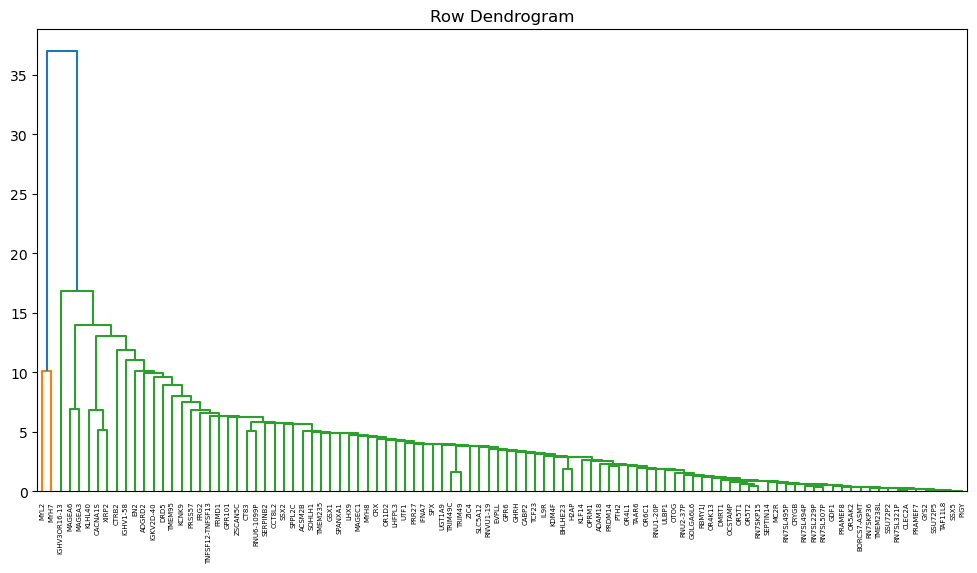

In [234]:
from scipy.cluster.hierarchy import dendrogram

# Plot the row dendrogram
plt.figure(figsize=(12, 6))
gene_plot = dendrogram(row_linkage, labels=expression_df_heatmap.index)
plt.title('Row Dendrogram')
plt.show()


In [235]:
# Extract reordered row indices
reordered_row_indices = gene_plot['leaves']

# Map reordered indices back to actual row names
reordered_row_names = expression_df_heatmap.index[reordered_row_indices]

# Print reordered row names
print("Reordered Row Names:")
print(reordered_row_names)

Reordered Row Names:
Index(['MYL2', 'MYH7', 'IGHV3OR16-13', 'MAGEA6', 'MAGEA3', 'KLHL40', 'CACNA1S',
       'XIRP2', 'CTRB2', 'IGHV1-58', 'EN2', 'ADGRD2', 'IGKV2D-40', 'DRD5',
       'TMEM95', 'KCNK9', 'PRSS57', 'FRG2', 'TNFSF12-TNFSF13', 'FRMD1',
       'GPR101', 'ZSCAN5C', 'CT83', 'RNU6-1099P', 'SERPINB2', 'CCT8L2', 'SSX2',
       'SPPL2C', 'ACSM2B', 'SOHLH1', 'TMEM235', 'GSX1', 'SPANXA1', 'LHX9',
       'MAGEC1', 'MYH8', 'CRX', 'OR1D2', 'LHFPL3', 'UTF1', 'PRR27', 'IFNA7',
       'SPX', 'UGT1A9', 'TRIM49C', 'TRIM49', 'ZIC4', 'SLC5A12', 'RNVU1-19',
       'EVPLL', 'GPR6', 'GHRH', 'CABP2', 'TCF23', 'IL9R', 'KDM4F', 'BHLHE23',
       'H2AP', 'KLF14', 'OPRM1', 'ADAM18', 'PRDM14', 'PTH2', 'OR4L1', 'TAAR6',
       'OR6C1', 'RNU1-20P', 'ULBP1', 'OTOG', 'RNU2-37P', 'GOLGA6L6', 'RBMY1J',
       'OR4K13', 'DMRT1', 'OCSTAMP', 'OR5T1', 'OR5T2', 'RN7SKP15', 'SEPTIN14',
       'MC2R', 'RN7SL495P', 'CRYGB', 'RN7SL494P', 'RN7SL229P', 'RN7SL507P',
       'GDF1', 'PRAMEF8', 'OR5AK2', 'BORCS7-ASMT', 'R

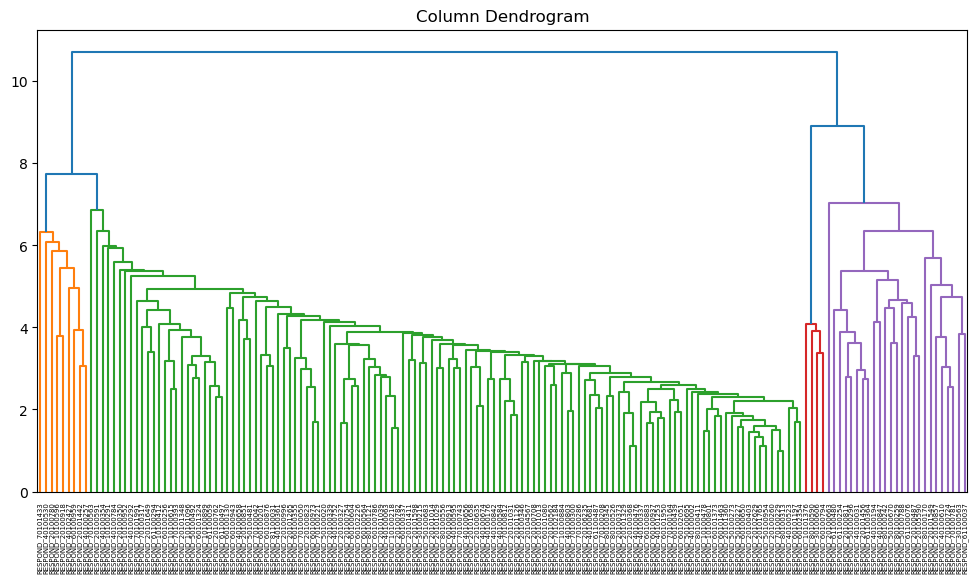

In [242]:
# Plot the column dendrogram
plt.figure(figsize=(12, 6))
sample_plot = dendrogram(col_linkage, labels=expression_df_heatmap.columns, orientation='top')
plt.title('Column Dendrogram')
plt.show()

In [246]:
# Extract reordered row indices
reordered_col_indices = sample_plot['leaves']

# Map reordered indices back to actual column names
reordered_col_names = expression_df_heatmap.columns[reordered_col_indices]

# Print reordered column names
print("Reordered Column Names:")
print(list(reordered_col_names))

Reordered Column Names:
['RESPOND_70101433', 'RESPOND_40100530', 'RESPOND_20100780', 'RESPOND_10100596', 'RESPOND_20100918', 'RESPOND_40102427', 'RESPOND_60100959', 'RESPOND_20101442', 'RESPOND_40100257', 'RESPOND_70100563', 'RESPOND_20100591', 'RESPOND_40100354', 'RESPOND_10100291', 'RESPOND_40100784', 'RESPOND_20100350', 'RESPOND_10100952', 'RESPOND_40100292', 'RESPOND_70101991', 'RESPOND_70100317', 'RESPOND_20101649', 'RESPOND_61100294', 'RESPOND_10100412', 'RESPOND_60100256', 'RESPOND_10100615', 'RESPOND_70100393', 'RESPOND_20101348', 'RESPOND_10101096', 'RESPOND_50100492', 'RESPOND_60101324', 'RESPOND_10100899', 'RESPOND_61100059', 'RESPOND_20100762', 'RESPOND_61100497', 'RESPOND_60100130', 'RESPOND_60100943', 'RESPOND_40100658', 'RESPOND_20100851', 'RESPOND_50100481', 'RESPOND_70100042', 'RESPOND_60100201', 'RESPOND_60100876', 'RESPOND_81100031', 'RESPOND_40100361', 'RESPOND_20100996', 'RESPOND_20101265', 'RESPOND_60100355', 'RESPOND_70100050', 'RESPOND_20100823', 'RESPOND_601009

## questions
### How do we prep data for heat map? In other tutorials, I see negative values. Like -1 to 2. I'm guessing some might be plotting the fold change calculation with baseline as healthy samples. 

In [239]:
def histogram_of_column(df, column):
    # Plot the distribution of p-values
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=30, color='blue', edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel('P-values')
    plt.ylabel('Frequency')
    plt.show()

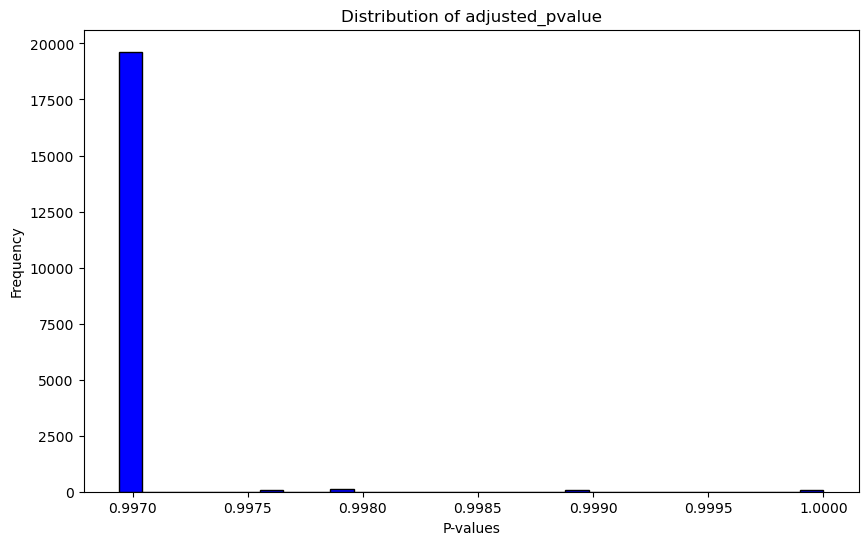

In [240]:
histogram_of_column(volcano_plot_df, column='adjusted_pvalue')

In [118]:
def volcano_plot(file_path, yaxis, xaxis):
    df = pd.read_csv(file_path)
    plt.scatter(x=df[xaxis],y=df[yaxis].apply(lambda x:-np.log10(x)),s=1)

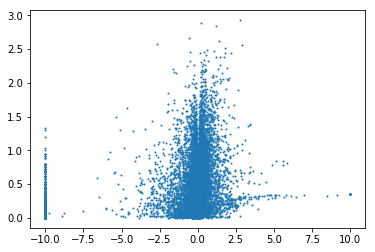

In [126]:
volcano_plot('5_112_RPL10', yaxis='pvalue', xaxis='logFC')